# **Business Running Case: Evaluating Personal Job Market Prospects in 2024**

# Introduction


In this project, we analyzed the "lightcast_job_postings.csv" dataset, which contains detailed job market information, including job titles, companies, locations, salaries, and various metadata. The dataset initially comprised 131 columns, offering a comprehensive view of job postings and associated attributes for evaluating personal job market prospects in 2024.

In [6]:
import polars as pl
import pandas as pd
import sqlite3
import plotly.express as px
import missingno as msno
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import us 

In [7]:
df = pd.read_csv("lightcast_job_postings.csv")

In [8]:
df.head()

,ID,LAST_UPDATED_DATE,LAST_UPDATED_TIMESTAMP,DUPLICATES,POSTED,EXPIRED,DURATION,SOURCE_TYPES,SOURCES,URL,...,NAICS_2022_2,NAICS_2022_2_NAME,NAICS_2022_3,NAICS_2022_3_NAME,NAICS_2022_4,NAICS_2022_4_NAME,NAICS_2022_5,NAICS_2022_5_NAME,NAICS_2022_6,NAICS_2022_6_NAME
0,1f57d95acf4dc67ed2819eb12f049f6a5c11782c,2024-09-06,2024-09-06 20:32:57.352 Z,0,2024-06-02,2024-06-08,6.0,"[\n ""Company""\n]","[\n ""brassring.com""\n]","[\n ""https://sjobs.brassring.com/TGnewUI/Sear...",...,44,Retail Trade,441,Motor Vehicle and Parts Dealers,4413,"Automotive Parts, Accessories, and Tire Retailers",44133,Automotive Parts and Accessories Retailers,441330,Automotive Parts and Accessories Retailers
1,0cb072af26757b6c4ea9464472a50a443af681ac,2024-08-02,2024-08-02 17:08:58.838 Z,0,2024-06-02,2024-08-01,NaN,"[\n ""Job Board""\n]","[\n ""maine.gov""\n]","[\n ""https://joblink.maine.gov/jobs/1085740""\n]",...,56,Administrative and Support and Waste Managemen...,561,Administrative and Support Services,5613,Employment Services,56132,Temporary Help Services,561320,Temporary Help Services
2,85318b12b3331fa490d32ad014379df01855c557,2024-09-06,2024-09-06 20:32:57.352 Z,1,2024-06-02,2024-07-07,35.0,"[\n ""Job Board""\n]","[\n ""dejobs.org""\n]","[\n ""https://dejobs.org/dallas-tx/data-analys...",...,52,Finance and Insurance,524,Insurance Carriers and Related Activities,5242,"Agencies, Brokerages, and Other Insurance Rela...",52429,Other Insurance Related Activities,524291,Claims Adjusting
3,1b5c3941e54a1889ef4f8ae55b401a550708a310,2024-09-06,2024-09-06 20:32:57.352 Z,1,2024-06-02,2024-07-20,48.0,"[\n ""Job Board""\n]","[\n ""disabledperson.com"",\n ""dejobs.org""\n]","[\n ""https://www.disabledperson.com/jobs/5948...",...,52,Finance and Insurance,522,Credit Intermediation and Related Activities,5221,Depository Credit Intermediation,52211,Commercial Banking,522110,Commercial Banking
4,cb5ca25f02bdf25c13edfede7931508bfd9e858f,2024-06-19,2024-06-19 07:00:00.000 Z,0,2024-06-02,2024-06-17,15.0,"[\n ""FreeJobBoard""\n]","[\n ""craigslist.org""\n]","[\n ""https://modesto.craigslist.org/sls/77475...",...,99,Unclassified Industry,999,Unclassified Industry,9999,Unclassified Industry,99999,Unclassified Industry,999999,Unclassified Industry


In [9]:
print(df.shape)

(72476, 131)


# **📌 Data Cleaning & Preprocessing**

***Drop Unnecessary Columns***

In [10]:
columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP",
    "NAICS2", "NAICS3", "NAICS4", "NAICS5", "NAICS6",
    "SOC_2", "SOC_3", "SOC_5"
]
df.drop(columns=columns_to_drop, inplace=True)

**To prepare the dataset for analysis, we undertook a thorough data cleaning and preprocessing process, including:**

1. **Dropping Irrelevant Columns:**

- We removed columns that were either redundant or not relevant to our analysis. These included unique identifiers (ID), URLs of job postings (URL, ACTIVE_URLS), and columns providing less granular versions of NAICS and SOC codes (NAICS2, SOC_3, etc.).
- The rationale for dropping these columns was to enhance data efficiency and clarity, reduce the dataset size, and focus on the most granular and meaningful data.

***Handling Missing Values***

<Axes: >

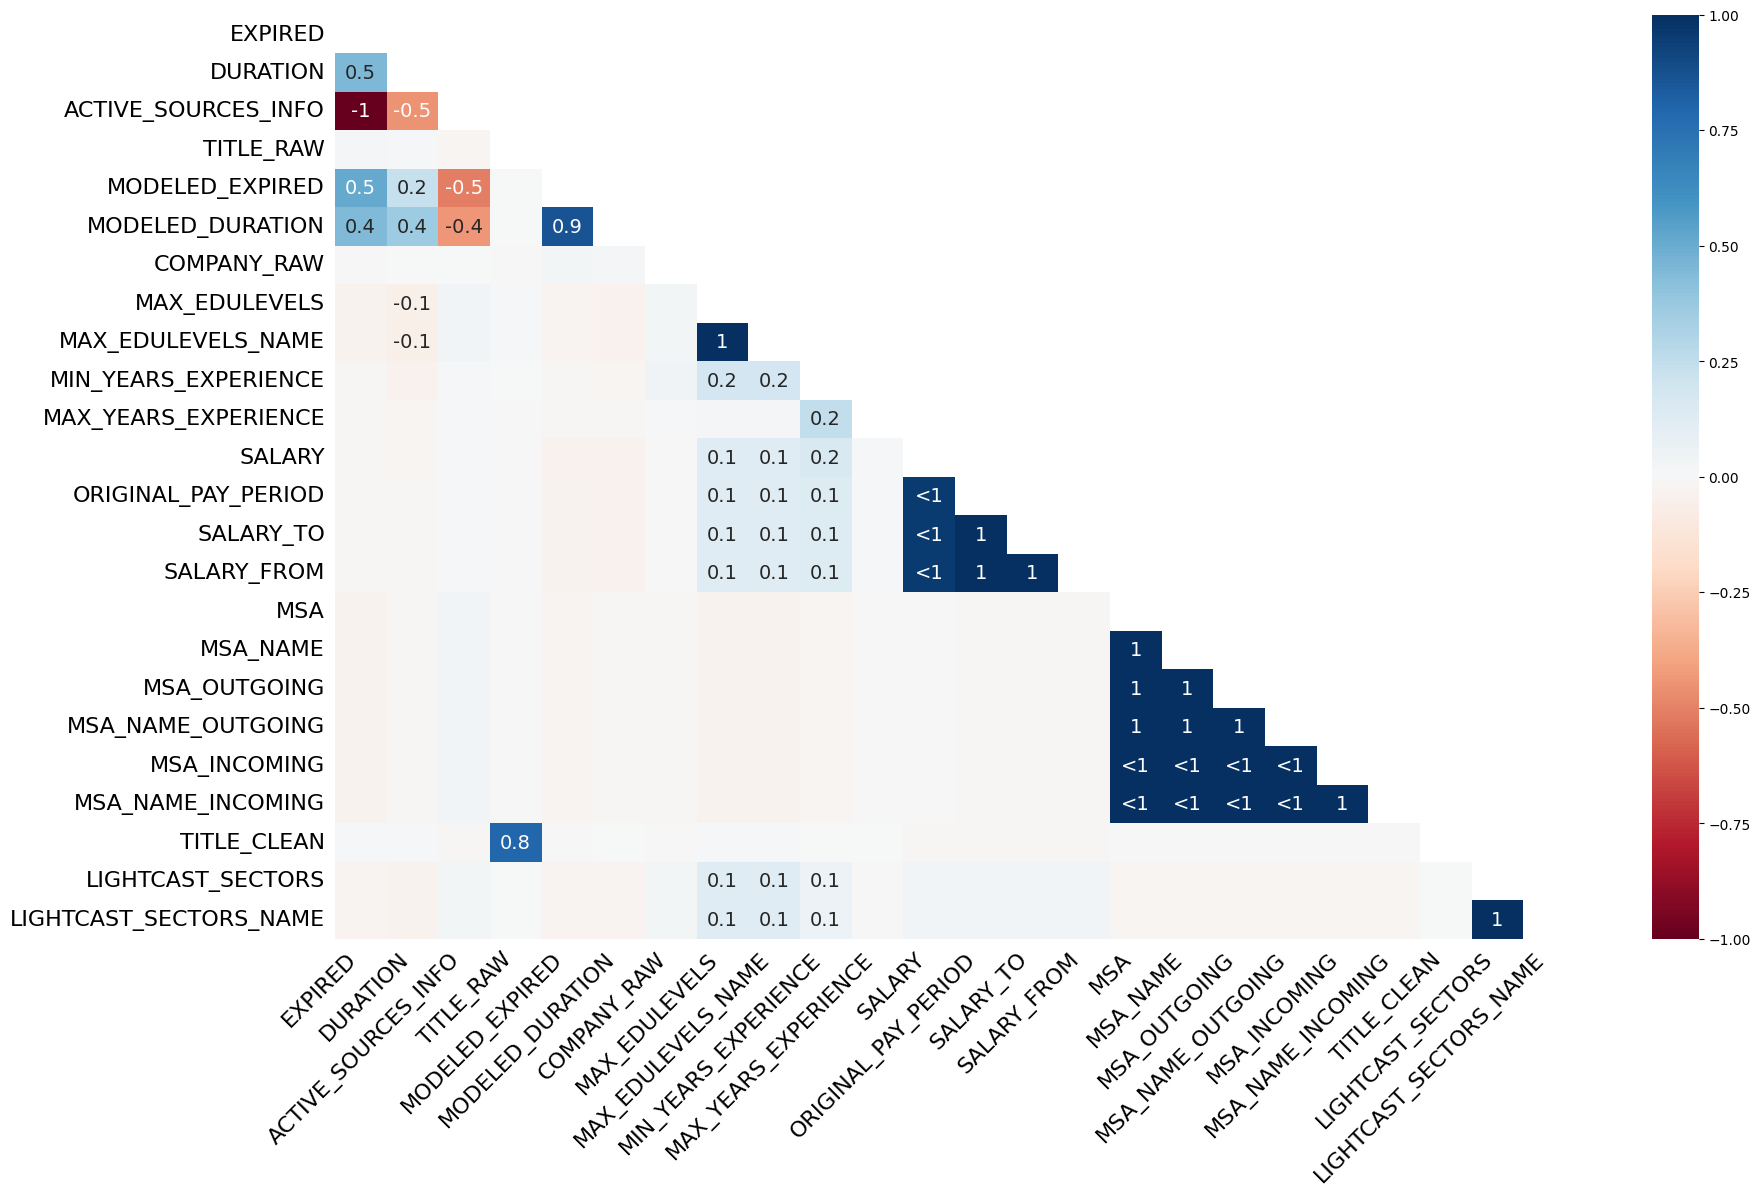

In [11]:
import missingno as msno
# Visualize missing data
msno.heatmap(df)

In [12]:
# Drop columns with >50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

# Fill missing values safely
df["NAICS_2022_6"] = df["NAICS_2022_6"].fillna(df["NAICS_2022_6"].median())
df["NAICS_2022_6_NAME"] = df["NAICS_2022_6_NAME"].fillna("Unknown")


2. **Handling Missing Values:**

- As seen in the heatmap above, it reveals that the columns
ACTIVE_SOURCES_INFO, MODELED_DURATION, and MODELED_EXPIRED contain significant missing values, suggesting potential data collection or extraction issues. Notably, DURATION and EXPIRED exhibit a moderate positive correlation (0.5), indicating that longer job durations might influence missingness in related columns. 
- Additionally, ACTIVE_SOURCES_INFO shows a strong negative correlation with other variables, implying a pattern where missing data in this column might coincide with gaps in others. 
- In contrast, columns like MSA, MSA_NAME, and LIGHTCAST_SECTORS have no missing values, providing a reliable foundation for further analysis. Addressing missing data in correlated columns through targeted imputation can prevent bias and enhance the accuracy of our analysis.

In [13]:
df = df.drop_duplicates(subset=["TITLE", "COMPANY", "LOCATION", "POSTED"], keep="first")

3. **Removing Duplicates:**

- To maintain unique job postings, duplicates were removed based on job title,
company, location, and posting date.
- This ensured that each job opportunity was only represented once, preventing
skewed analysis results.

# Impact of Data Cleaning

The data cleaning process resulted in a more streamlined and manageable dataset, eliminating redundancy and potential inconsistencies. This step set the foundation for accurate and insightful analysis in the subsequent phases of the project.

# **📌 Exploratory Data Analysis (EDA)**

In [14]:
top_industries = df["NAICS_2022_6_NAME"].value_counts().nlargest(15)
fig = px.pie(
    names=top_industries.index, 
    values=top_industries.values, 
    title="Top 15 Job Posting Industries"
)
fig


# **Top 15 Job Posting Industries**

In our analysis, we looked at the top industries with the most job postings to get a sense of where the demand is highest. The pie chart shows that **22.6%** of the postings fall under the **Unclassified Industry** category, suggesting that many roles either span multiple sectors or lack clear classification. This made us consider the potential limitations in how industries are labeled in the data.

We also noticed a strong demand for skills in **technology and consulting**. For example, **Custom Computer Programming Services** made up **12.1%** of the postings, while **Management Consulting Services** accounted for **11.3%**. This highlights a significant need for both tech and management skills in today’s job market.

Interestingly, several tech-focused industries, such as **Software Publishers** and **Computer Systems Design Services**, showed up prominently in the chart. This aligns with the growing demand for IT and consulting professionals, which didn’t surprise us given the ongoing digital transformation across industries.

We also found that **finance and healthcare** sectors have a notable share of job postings, indicating steady demand in these fields. On the flip side, areas like **Accounting** and **Temporary Help Services** had fewer listings, suggesting these might be more niche markets.

In [15]:
# 1. Filter the main df into df_roles
df_roles = df[df["TITLE_NAME"].str.contains(" Data Analysts|Business Intelligence Analysts|Data Analytics Engineers|Data and Reporting Analysts|"
    "Data Governance Analysts|Data Quality Analysts|Data Analytics Analysts|Data Management Analysts|"
    "Data Modelers|Lead Data Analysts|Research Data Analysts|IT Data Analysts|Data Analytics Manager|"
    "Lead Business Intelligence Analysts|Data Science Analysts|Data Analytics Leads|"
    "Business Intelligence Data Analysts|Data Operations Analysts|Health Data Analysts|"
    "Data analytics consultants|Enterprise Data Analysts", case=False, na=False)]

# 1. Make a copy to avoid SettingWithCopyWarning
df_roles = df_roles.copy()

# 2. Convert POSTED to datetime (if not already)
df_roles["POSTED"] = pd.to_datetime(df_roles["POSTED"])

# 3. Create a monthly column as a Timestamp
df_roles["month"] = df_roles["POSTED"].dt.to_period("M").dt.to_timestamp()

# 4. Group by month and role
monthly_counts = df_roles.groupby(["month", "TITLE_NAME"]).size().reset_index(name="count")

fig = px.area(
    monthly_counts,
    x="month",
    y="count",
    color="TITLE_NAME",
    title="Monthly Trend of Data-Related Job Postings by Role (Stacked Area)"
)
fig.show()

# **Monthly Trend of Data-Related Job Postings by Role**

In the above Stacked Area Chart, we focused on understanding the monthly trends for various data-related job roles. To do this, we filtered the dataset to include only job titles containing keywords like "Data Analysts," "Business Intelligence Analysts," and "Data Engineers," among others. After filtering, we converted the posting dates into a proper datetime format and created a new column to track monthly trends. We then grouped the data by month and job title to visualize how the demand for these roles evolved over time.

The stacked area chart we generated illustrates that the demand for data-related roles has shown a consistent upward trend, especially after mid-June 2024. One of the most noticeable patterns is the significant share held by roles such as **Big Data Analysts and Business Intelligence Analysts**, which suggests that organizations are increasingly seeking professionals who can handle large-scale data analysis and provide actionable insights.

Interestingly, we observed that the demand for **Data Analysts and Data Analytics Engineers** also increased steadily, indicating a growing need for professionals who can not only interpret data but also manage the infrastructure required for analysis. This aligns with the broader industry trend of integrating advanced analytics into decision-making processes.

We also found that more specialized roles like **Clinical Data Analysts and Customer Data Analysts** are gaining traction, although they represent a smaller share of the total postings. This could imply that industries such as healthcare and customer analytics are gradually expanding their analytics teams.

In [16]:
fig = px.pie(df_roles, names="REMOTE_TYPE_NAME", title="Remote vs. On-Site Jobs")
fig.show()

# **Remote vs. On-Site Jobs (Data Roles)**

We created a Pie Chart to explor the distribution of remote, on-site, and hybrid roles for data-related jobs. The chart shows that **73.8%** of postings do not specify a preference, suggesting either data gaps or employer flexibility. Among specified roles, **20.4% are remote**, indicating a strong demand for remote work. Hybrid roles account for **4%**, while fully on-site roles are only **1.79%**.

These findings suggest a clear shift towards remote and flexible work arrangements in the data field. Highlighting remote work skills could be advantageous for job seekers in this area.

In [17]:
# 🔹 Step 2: Aggregate Job Counts by State
job_counts = df_roles["STATE_NAME"].value_counts().reset_index()
job_counts.columns = ["state", "job_postings"]

# 🔹 Step 3: Convert Full State Names to Abbreviations
job_counts["state"] = job_counts["state"].apply(lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else x)

# 🔹 Step 4: Create Choropleth Map
fig = px.choropleth(
    job_counts,
    locations="state",
    locationmode="USA-states",  # Correct location mode for US states
    color="job_postings",  # Color by job count
    hover_name="state",
    color_continuous_scale="Viridis",  # High-contrast color scheme
    title="Data-Related Job Postings Across the USA",
    scope="usa"  # Focus on the USA
)

fig.show()

# **Data-Related Job Postings Across the USA**

We created a **Choropleth Map** to understand the geographical distribution of data-related job postings across the United States. To do this, we aggregated the job counts by state and converted full state names to abbreviations to ensure consistency in the map. We then used a choropleth map to visualize how job postings are spread across different states.

From the map, we can see that **states like California, Texas, and Florida** have the highest concentrations of data-related job postings, indicated by the brighter yellow shades. This pattern suggests that these states are major hubs for data-related roles, likely due to their large tech industries and the presence of major corporations.

In contrast, **several states in the Midwest and some in the Mountain region** show darker shades, indicating fewer job opportunities in data-related fields. This could imply either a lower demand for such roles or a smaller tech industry presence in those areas.

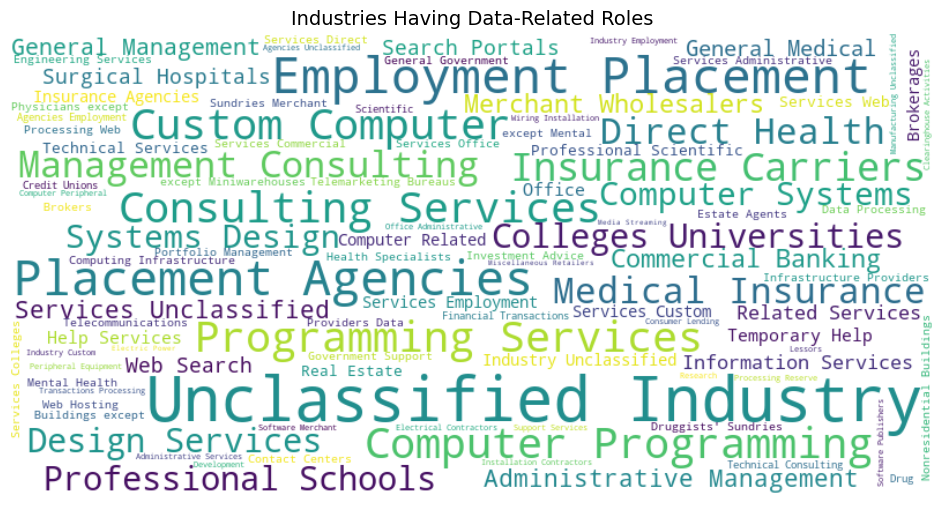

In [18]:
# Get industries associated with these roles
industry_text = " ".join(df_roles["NAICS_2022_6_NAME"].dropna())

# Generate word cloud
wordcloud = WordCloud(
    width=800, height=400, background_color="white", 
    colormap="viridis", max_words=100
).generate(industry_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Industries Having Data-Related Roles", fontsize=14)
plt.show()

# **Industries Having Data-Related Roles**

With this WordCloud, we aimed to identify the industries that most frequently offer data-related roles. We extracted industry names from the dataset, combined them into a single text string, and then generated a word cloud to visualize which industries appeared most often.

From the word cloud, we can see that **"Unclassified Industry," "Programming Services," "Consulting Services," and "Insurance Carriers"** are some of the most prominent terms. The large size of these words suggests that these industries have a significant number of data-related job postings. This pattern highlights the growing importance of data roles in both tech-heavy sectors like programming and consulting as well as in more traditional fields such as insurance.

Other notable industries in the word cloud include **"Computer Systems Design," "Employment Placement Agencies," and "Direct Health Services."** Their visibility suggests a broad demand for data professionals across diverse sectors, emphasizing that data analytics skills are valuable beyond just the tech industry.

This indicate that the demand for data roles is not limited to a few industries but is spread across both tech-focused and traditional sectors. This reinforces the idea that data skills are becoming essential across the board.

# **Key Findings**

1. **Industry Demand:**

- Programming Services, Consulting Services, and Insurance emerged as leading industries for data-related roles, indicating a widespread need for data skills beyond traditional tech sectors.
- The prominence of Unclassified Industry suggests potential gaps in data classification or a diverse range of roles that do not fit into conventional categories.

2. **Geographical Distribution:**

- California, Texas, and Florida were identified as major hubs for data-related jobs, while several Midwestern and Mountain states showed fewer opportunities.
- This pattern suggests that professionals may find more job prospects by focusing on these high-demand states.

3. **Work Arrangement Preferences:**

- A significant share of job postings preferred remote and hybrid roles, with over 20% specifically offering remote options.
- The limited proportion of fully on-site roles reflects a broader shift towards flexible work models in the data industry.

4. **Role-Specific Trends:**

- There is a clear upward trend in demand for roles such as Big Data Analysts and Business Intelligence Analysts, highlighting the growing importance of both technical and analytical skills.
- Specialized roles like Clinical Data Analysts and Customer Data Analysts are also gaining traction, indicating expanding opportunities in niche areas.

# **Conclsuion**

Our analysis revealed that the demand for data-related skills is both substantial and diverse, spanning multiple industries and regions across the United States. Key sectors such as tech, consulting, and insurance show the most significant opportunities, while states like California, Texas, and Florida lead in job postings.

The strong preference for remote and hybrid roles highlights the importance of flexibility in the current job market. Meanwhile, the consistent rise in demand for specialized data roles suggests a promising outlook for professionals equipped with both analytical and domain-specific skills.

Overall, these findings suggest that focusing on high-demand industries, enhancing remote work capabilities, and acquiring specialized skills can significantly boost job prospects in the data field.